# 3. LangGraph basics

This notebook will very briefly go through the basics of LangGraph.

<a target="_blank" href="https://colab.research.google.com/github/IT-HUSET/ai-workshop-250121/blob/main/lab/3-langgraph-basics.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a><br/>

## Setup

### Install dependencies

In [24]:
from attr import dataclass
%pip install httpx~=0.28.1 openai~=1.57 --upgrade --quiet
%pip install python-dotenv~=1.0 docarray~=0.40.0 pypdf~=5.1 --upgrade --quiet
%pip install chromadb~=0.5.18 lark~=1.2 --upgrade --quiet
%pip install langchain~=0.3.10 langchain_openai~=0.2.11 langchain_community~=0.3.10 langchain-chroma~=0.1.4 --upgrade --quiet
%pip install langgraph~=0.2.56 --upgrade --quiet

# If running locally, you can do this instead:
#%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Load environment variables

In [25]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

# If running in Google Colab, you can use this code instead:
# from google.colab import userdata
# os.environ["AZURE_OPENAI_API_KEY"] = userdata.get("AZURE_OPENAI_API_KEY")
# os.environ["AZURE_OPENAI_ENDPOINT"] = userdata.get("AZURE_OPENAI_ENDPOINT")
# os.environ["ANTHROPIC_API_KEY"] = userdata.get("ANTHROPIC_API_KEY")

### Setup Chat Model

In [26]:
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings
api_version = "2024-10-01-preview"
llm = AzureChatOpenAI(deployment_name="gpt-4o-mini", temperature=0.0, openai_api_version=api_version)

## Basic LangGraph concepts

![Graph](https://github.com/IT-HUSET/ai-workshop-250121/blob/main/images/graph.png?raw=true)

Below are some concepts specific to LangGraph, related to modelling logic and behaviour as graphs of nodes and edges.

At its core, LangGraph models agent workflows as graphs. You define the behavior of your agents using four key components:

### 1. State
To keep track of the state of the graph, we use a state object. This object serves as the input schema for all Nodes and Edges in the graph. All nodes are expected to communicate with that schema.

A state object can be anything from a simple dictionary to a complex object. The state object is passed between nodes in the graph and is updated as the graph progresses. **The main documented way** to specify the schema of a graph is by using `TypedDict`. However, Pydantic BaseModel and dataclasses are also supported.
Read more about states [here](https://langchain-ai.github.io/langgraph/concepts/low_level/#state).

A simple example of a state object using `TypedDict` can look like this:

```python
from typing_extensions import TypedDict

class MyState(TypedDict):
    foo: str
    bar: str
```

#### Messages
Questions and instructions sent to an LLM are called messages, and these are the most common form of state. Messages come in different flavours, corresponding to different roles, for instance _**System, Human, AI, Tool**_ etc. Since having a list of messages in your state is so common, there is also a predefined state class called [`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate), which makes it easy to use messages.

```python
from langgraph.graph import MessagesState

# This state class will have an additional field called `messages`
class MyStateWithMessages(MessagesState):
    foo: str
    bar: str
```

Read more about messages [here](https://python.langchain.com/docs/concepts/messages/).
![Graph](https://github.com/IT-HUSET/ai-workshop-250121/blob/main/images/langchain-messages.png?raw=true)

### 2. Nodes
A node is a unit of work in a graph. A node can be implemented as a simple function or by using a (callable) class. Read more about nodes [here](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes).

The first positional argument of a node is the **state schema** used for the graph. By default, every modification of a state field will overwrite the previous value, however it's possible to change this behaviour by using **[reducer functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers)**.

### 3. Edges
An edge is a connection - or a transition - between two nodes. There are different types of edges, for instance predefined extry and exit nodes, simple "normal" edges, and conditional edges. A **_conditional_** edge means that the transition is dynamically decided based on the state of the graph.

Read more about edges [here](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges).

### 4. Graph

The Graph is an abstraction that models an agent workflows, and is built by composing a collection of nodes and edges. Using this abstraction, you can create complex, looping workflows that evolve the State over time. And because *State* is central to the process, the **`StateGraph`** class is the main graph class to use.

Before using it, the graph is compiled to perform a few basic checks on the graph structure.

Read more about edges [here](https://langchain-ai.github.io/langgraph/concepts/low_level/#graphs).


## Build a simple Graph

### Setting up the State Schema

We'll begin by defining the [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) of the graph, using the `TypedDict` class from python's `typing` module. TypedDict is simply a dictionary with a fixed set of keys and some typing support. At runtime, it’s still a regular dictionary.

In [27]:
from typing import TypedDict, NotRequired

# You can define optional keys by setting `total=False` or by using `NotRequired` (e.g. `NotRequired[str]`)
class MyState(TypedDict):
    name: str
    graph_state: NotRequired[str]

#### Examples of use

In [28]:
sample_state: MyState = {"name": "Zaphod Beeblebrox.", "graph_state": "I am happy!"}

# Incorrect use
invalid_state: MyState = {"name": "Zaphod Beeblebrox.", "age": 42} # This will result in warning because `age` is not in the schema

### Creating some Nodes

In its simplest form, [Nodes](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes) are just python functions, but you can also model them as "callable" classes.

Because the state is a `TypedDict` with schema as defined above, each node can access the key, `graph_state`, with `state['graph_state']`.

By default, the new value returned by each node will override the prior state value.

In [29]:
def hello_node(state: MyState) -> MyState:
    print("---Hello Node---")
    state["graph_state"] = f"Hello, {state['name']}!"
    return state

def happy_node(state: MyState) -> MyState:
    print("---Happy Node---")
    state["graph_state"] = state['graph_state'] + " You look happy!"
    return state

def sad_node(state: MyState) -> MyState:
    print("---Sad Node---")
    state["graph_state"] = state['graph_state'] + " You look sad..."
    return state

### Defining Edges - connecting the nodes

Normal Edges are used if you want to *always* go from one node to another, for example, `START` to `node_1`.

Below we define a *[conditional edge](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges)*, to dynamically decide the next node to visit based on some logic.

In [30]:
import random
from typing import Literal

# Note: The type of return value (Literal) is used for validation and display/debug purposes
def decide_mood(state) -> Literal["happy_node", "sad_node"]:
    # Often, we will use state to decide on the next node to visit
    user_input = state['graph_state']

    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "happy_node"

    # 50% of the time, we return Node 3
    return "sad_node"

## Graph Construction

Now, we build the graph from our components defined above.

We begin by initializing a [StateGraph class](https://langchain-ai.github.io/langgraph/concepts/low_level/#stategraph) with the `MyState` class we defined above.

Then, we add our nodes and edges.

We use the [`START` Node, a special node](https://langchain-ai.github.io/langgraph/concepts/low_level/#start-node) that sends user input to the graph, to indicate where to start our graph.

The [`END` Node](https://langchain-ai.github.io/langgraph/concepts/low_level/#end-node) is a special node that represents a terminal node.

Finally, we [compile our graph](https://langchain-ai.github.io/langgraph/concepts/low_level/#compiling-your-graph) to perform a few basic checks on the graph structure.

We can visualize the graph as a [Mermaid diagram](https://github.com/mermaid-js/mermaid).

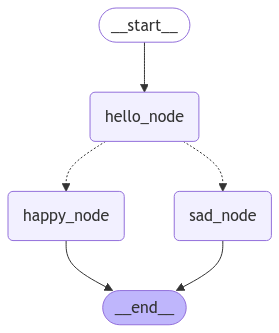

In [31]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(MyState)
builder.add_node("hello_node", hello_node)
builder.add_node("happy_node", happy_node)
builder.add_node("sad_node", sad_node)

# Logic
builder.add_edge(START, "hello_node")
builder.add_conditional_edges("hello_node", decide_mood)
builder.add_edge("happy_node", END)
builder.add_edge("sad_node", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## Graph Invocation

The compiled graph implements the unified **[`Runnable`](https://python.langchain.com/v0.1/docs/expression_language/interface/)** protocol of **LangChain**, meaning it can be **invoked** or **streamed** in the same way as any other LangChain component.

The input when invoking our graph is the initial state of the graph, defined by the state schema, i.e. `MyState` in our case.

When `invoke` is called, the graph starts execution from the `START` node.

It progresses through the defined nodes (`hello_node`, `happy_node` (or `sad_node`)) in order.

Each node function receives the current state and returns a new value, which overrides the graph state.

The execution continues until it reaches the `END` node.

In [32]:
input: MyState = {"name" : "TojohoBe"}

graph.invoke(input)

---Hello Node---
---Sad Node---


{'name': 'TojohoBe', 'graph_state': 'Hello, TojohoBe! You look sad...'}

<br/>
<br/>
<br/>
<br/>
<br/>

----

## EXERCISE! Build your own graph

**Task:**
- Create a graph that takes a name as input, converts it into a cooler sounding name and generates a mood.

#### Below is a skeleton for the graph.

/home/vscode/.local/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:502: UserWarning: typing.NotRequired is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


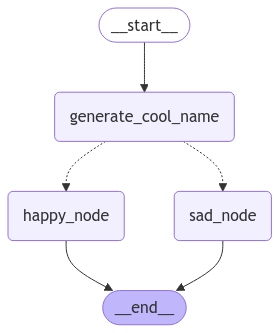

In [38]:
# STATE
class ExerciseState(TypedDict):
    # TODO: Add name and mood
    name: str
    mood: NotRequired[str]

# NODES
def generate_cool_name(state: ExerciseState) -> ExerciseState:
    print("---Generate Cool Name---")
    initial_mood = "😑"
    new_name = llm.invoke(f"Generate a cool name based on the name {state['name']}. Answer with just the name.").content
    state["name"] = f"Hello, {new_name}!"
    return state

def happy_node(state: ExerciseState) -> ExerciseState:
    print("---Happy Node---")
    state["mood"] = "happy!"
    return state # TODO: Return the new state

def sad_node(state: ExerciseState) -> ExerciseState:
    print("---Sad Node---")
    state["mood"] = "sad!"
    return state # TODO: Return the new state


# EDGES
def decide_mood(state: ExerciseState) -> Literal["happy_node", "sad_node"]:
    name = state['name']
    if len(name) % 2 == 0:
        return "happy_node"
    return "sad_node"


# GRAPH
# Configure nodes
builder = StateGraph(ExerciseState)
builder.add_node("generate_cool_name", generate_cool_name)

builder.add_node("happy_node", happy_node)
builder.add_node("sad_node", sad_node)

# Configure edges
builder.add_edge(START, "generate_cool_name")
# TODO: Add missing edges
builder.add_conditional_edges("generate_cool_name", decide_mood)
builder.add_edge("happy_node", END)
builder.add_edge("sad_node", END)

# Compile and view
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [57]:
# Invoke
graph.invoke({"name": "john"})

---Generate Cool Name---
---Sad Node---


{'name': 'Hello, Jaxon!', 'mood': 'sad!'}